<a href="https://colab.research.google.com/github/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/Bootcamp_DataScience_projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/img/Banner_Bootcamp.png?raw=true">

#Projeto Final de Conclusão de Curso
###Bootcamp Data Science Aplicada 2 by [Alura](https://www.alura.com.br/) 
####Autor: Helton Cordeiro
e-mail: heltoncordeiro@gmail.com

Junho-Agosto/2021.



---

# **Objetivo desse notebook**

Após os dados disponibilizados pelo Hospital Sírio Libânes ter sido tratados em [notebook próprio](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/projeto_final_tratamento_dados.ipynb) vamos começar a trabalhar com os Modelos de Machine Learning com o seguinte objetivo:


#### **Prever** quais pacientes precisarão ser admitidos(as) na UTI e com isso **definir** qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.

Serão avaliados 10 modelos de Machine Learning.
A primeira execução será com os parâmetros default para obtermos o valor da [Métrica AUC](#roc_auc), depois em um notebook separado processamentos os modelos com ajustes nos parâmetros para obter um AUC melhorado e ao final espero encontrar um modelos que possa auxiliar a atingir o objetivo.

---

#Configurações Iniciais

##Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

## Importando as funções auxiliares

* Arquivo funcoes.py contém as funções python que serão utilizados pelo projeto.

In [2]:
import funcoes
from importlib import reload
reload(funcoes)

<module 'funcoes' from '/content/funcoes.py'>

In [3]:
from funcoes import executa_modelos, roda_modelo_cv
from funcoes import plotar_matrix_confusao, plotar_matrix_confusao_modelos, montar_classificacao, plotar_media_curva_roc
from funcoes import montar_dataframe_medias_AUC, montar_dataframe_avaliacao

## Valores iniciais

In [4]:
pd.options.display.float_format = "{:,.6f}".format
sns.set()
sns.set_style("ticks")

mpl.rcParams['figure.figsize']= (6,6)
mpl.rcParams['figure.titlesize']= 18
mpl.rcParams['figure.titleweight']= 'bold'
mpl.rcParams['axes.labelsize']= 16
mpl.rcParams['axes.titlesize']= 18
mpl.rcParams['axes.titleweight']= 'bold'
mpl.rcParams['xtick.labelsize']= 11
mpl.rcParams['ytick.labelsize']= 11
mpl.rcParams['legend.fontsize']= 'large'
mpl.rcParams['date.autoformatter.day']= '%d/%m/%Y'
mpl.rcParams['grid.color']='grey'
mpl.rcParams['grid.linestyle']= '--'
mpl.rcParams['grid.linewidth']= 0.5

In [5]:
rstate = 73246
np.random.seed(rstate)

## Carregando os dados
Vamos carregar o arquivo de dados tratados e sem as colunas com alta correção.

O processo de tratamento dos dados estão nesse notebook [projeto_final_tratamento_dados.ipynb](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/projeto_final_tratamento_dados.ipynb).


### Carga dos dados

In [6]:
url='https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/dados/Kaggle_Sirio_Libanes_ICU_Prediction-tratado-sem-corr.xls?raw=true'
dados_raw = pd.read_excel(url, index_col=0)
dados = dados_raw.copy()

### Informações do dataset

Nossos dados não estão muito desbalanceados, temos **64%** dos resultados para a classe 0 (Não Internou) e **36%** para a classe 1 (Internou).

In [7]:
print(40*"---")
print("\nNosso dataframe tem %s linhas e %s colunas\n" %(dados.shape[0], dados.shape[1]))
print(40*"---")
print("Distribuição do ICU\n%s\n" %(dados['ICU'].value_counts(normalize=True)))
print(40*"---")
dados.info(verbose=False)
print(40*"---")
display(dados.head())

------------------------------------------------------------------------------------------------------------------------

Nosso dataframe tem 294 linhas e 95 colunas

------------------------------------------------------------------------------------------------------------------------
Distribuição do ICU
0   0.642857
1   0.357143
Name: ICU, dtype: float64

------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 293
Columns: 95 entries, AGE_ABOVE65 to ICU
dtypes: float64(46), int64(49)
memory usage: 220.5 KB
------------------------------------------------------------------------------------------------------------------------


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PCR_MEDIAN,PCR_DIFF,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MIN,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
0,1,6,0,0,0,0,0,1,1,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.183673,-1,-0.868365,-1,-0.742004,-1,-0.945093,-1,-0.891993,-1,0.090147,-1,-1,-0.932246,...,-0.875236,-1,-1,0.363636,-1,-0.540721,-1,-0.518519,-1,-1,0.345679,-1,-0.028571,-1,-0.997201,-1,-0.990854,-1,-0.825613,-1,-0.836145,-1,-0.994912,-1,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.898990,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.357143,-1,-0.912243,-1,-0.742004,-1,-0.958528,-1,-0.780261,-1,0.144654,-1,-1,-0.959849,...,-0.939887,-1,-1,0.363636,-1,-0.399199,-1,-0.703704,-1,-1,0.345679,-1,0.085714,-1,-0.995428,-1,-0.986662,-1,-0.846633,-1,-0.836145,-1,-0.978029,-1,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,0.959596,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1
2,0,4,1,0,0,0,0,0,0,0,1,1,-0.263158,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.972789,-1,-1.000000,-1,0.326531,-1,-0.968861,-1,-0.194030,-1,-0.316589,-1,-0.891993,-1,-0.203354,-1,-1,-0.959849,...,-0.503592,-1,-1,0.363636,-1,-0.564753,-1,-0.777778,-1,-1,0.580247,-1,0.200000,-1,-0.989549,-1,-0.956555,-1,-0.846633,-1,-0.937349,-1,-0.978029,-1,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.878788,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.935113,-1,-1.000000,-1,0.357143,-1,-0.913659,-1,-0.829424,-1,-0.938084,-1,-0.851024,-1,0.358491,-1,-1,-0.959849,...,-0.990926,-1,-1,0.363636,-1,-0.457944,-1,-0.592593,-1,-1,0.345679,-1,0.142857,-1,-0.998507,-1,-0.991235,-1,-0.846633,-1,-0.903614,-1,-1.000000,-1,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.939394,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.357143,-1,-0.891012,-1,-0.742004,-1,-0.958528,-1,-0.891993,-1,0.291405,-1,-1,-0.959849,...,-0.997732,-1,-1,0.363636,-1,-0.292390,-1,-0.666667,-1,-1,0.345679,-1,0.085714,-1,-0.997947,-1,-0.988948,-1,-0.846633,-1,-0.884337,-1,-1.000000,-1,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,0.919192,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0


---


#Métricas

Antes de iniciar a apresentação dos Modelos de Machine Learning, é importante conhecer as metrícas obtidas a partir dos modelos, para depois tormarmos a decisão sobre o melhor modelo.




## O que são métricas?

Métricas são medidas quantificáveis usadas para analisar o resultado de um processo, ação ou estratégia específica. De maneira geral, são **medidas de desempenho**. 

Uma métrica é um número que representa a medida que você vai acompanhar para entender o que dá certo (ou não) no seu trabalho.

Os modelos de Machine Learning buscam prever um resultado baseado no que aprendeu e no nosso caso temos um dataFrame com várias informações de pacientes. E para definir o melhor modelo devemos considerar nosso problema, que é a necessidade ou não de UTI (classificação binária), e como resultado das previsão comparado com o valor real podemos ter como resultado uma matriz 2x2 conforme apresentado na Matriz de Confusão abaixo:



<img src="https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/img/Matriz_Confusao.png?raw=true?raw=true">




***ATENÇÃO*** - *Deve-se prestar atenção as label e não a posição na matriz, pois é comum aparecer com as posições invertidas! Tanto da label quando do Previsto/Real.*

Da matriz de confusão, obtemos as seguinte informações:

Considerando as labels (Negativo=0 e Positivo=1) dos eixos x, y (Previsto, Real), interpretamos como o quadro abaixo:

Coluna 1 | Coluna 2
--- | ---
(0,0) = Verdadeiro Negativo | (1,0) = Falso Positivo
(0,1) = Falso Negativo | (1,1) = Verdadeiro Positivo


* VP - Verdadeiro Positivo - Modelo previu Positivo (1) para internar e realmente internou (1).
* VN - Verdadeiro Negativo - Modelo previu Negativo (0) para internar e realmente não internou (0).
* FP - Falso Positivo - Modelo apontou Positivo (1) para internar e não internou (0)
* FN - Falso Negativo - Modelo apontou Negativo (0) para internar e internou (1)

Em verde, o que o modelo acertou, e em salmão o que errou.




---


### **Métrica 'Accuracy'**

Na acurácia fazemos a contagem do que acertamos. Essa é uma métrica bastante usada e bastante perigosa. Ela esconde alguns possíveis defeitos do seu modelo e pode te levar a decisões erradas, exemplo, classificação de fraude, em 100mil observações, 1% é fraude, se o modelo for muito ruim e disser que todos os valores são de não-fraude, terá uma acurácia de 99%, parece bom mas o modelo é inútil.

$$Accuracy = \frac {VP + VN}{VP + VN + FP + FN}$$



---

### **Métrica 'Precision'**

De todas as minhas classificações positivas, quantas são realmente positivas.

$$Precision = \frac {VP}{VP + FP}$$


---

### **Métrica 'Recall'**

De todas as classes positivas, quantas eu realmente **classifiquei corretamente**. Também conhecida como Sensibilidade.

$$Recall = \frac {VP}{VP + FN}$$

 


---

### **f1-score**

É a Média Harmônica entre *precision* e *recall*.

Mas por que média harmônica?
É a média que nos dá um alerta que de alguma das métricas está muito baixo.
Utiliza-se a média harmônica para tornar a métrica sensível a desproporções das taxas.

$$f1score = 2 * \frac {(Precision * Recall)}{(Precision + Recall}$$

---




<a name="roc_auc"></a>
###**AUC - Curva ROC AUC**

#### O que é Curva ROC

A curva ROC é uma curva que serve, de uma forma muito simplista, para validar um teste. Do Inglês ROC (Receiver Operator Characteristic Curve), em português, Curva Característica de Operação do Receptor.

A AUC é a área que se forma abaixo da curva ROC.


####Como interpretar a AUC

A AUC é calculada como uma área que varia de 0 a 1, mas a interpretação do **valor** da **AUC é uma probabilidade**. Probabilidade de que, se fizermos duas observações de nossas previsões, elas serão **ordenadas** da maneira correta. Ou seja, uma AUC de 0.90 (que tem uma área de 90%) tem a interpretação de que, se duas observações forem feitas sobre qualquer um dos valores previstos, a probabilidade de serem corretamente ordenados é a própria AUC, 90%. Isso explica por que a AUC mínima é 0,50, porque se o seu modelo é completamente aleatório, a probabilidade de duas observações serem classificadas corretamente é de 50%, ou seja, aleatória. Assim como a AUC máxima é 1.


![](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/img/auc_2.gif?raw=true)








####**A curva AUC dá a idéia de quão bem as classes estão separadas**

Um bom modelo é um modelo que pode separar bem as duas classes; portanto, quanto menor a interseção entre as duas classes que nosso modelo tiver, melhor será e consequentemente maior será a AUC.

![](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/img/auc_3.gif?raw=true)

####**AUC não é sensível à prevalência**

Um problema que ocorre com outros tipos de métricas (como Precision ou Recall), é que a prevalência (ou seja, a razão entre as classes) afetou bastante essas métricas, mas a AUC não sofre com isso, no gif abaixo, temos um exemplo real. A curva da AUC está no canto direito em verde e observamos que ela não se move para nenhum nível de prevalência.

![](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/img/auc_4.gif?raw=true)


Fonte: [Matriz de Confusão e AUC ROC](https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107) escrito por **Marcos Silva**

## Mais Precisão ou Mais Sensibilidade?

Não é possível ter um modelo Preciso e Sensível ao mesmo tempo, ou melhoramos uma métrica ou melhoramos a outra.

No nosso caso um **Falso Negativo** e mais relevante, pois se nosso modelo apontar que o paciente não necessitará de UTI e vier a precisar, no pior caso uma visa seria perdida, então devemos ser mais sensíveis (Recall).

Assim precisamos:

* Acertar o maior número de VP (Verdadeiros Positivo)
* Diminuir os FN (Falsos Negativos) para evitar perda de pacientes
* Diminuir os FP (Falsos Positivos) para não sobrecarregar o sistema de saúde.





---


#Modelos de Machine Learning
Relação dos Modelos que serão testados nesse projeto, foram selecionados por resolverem problemas de classificação binária e *aprendizado supervisionado*. 

* **Aprendizado Supervisionado**

A característica básica de sistemas de *aprendizado supervisionado* é que os dados que utilizamos para treiná-los contém a resposta desejada, isto é, contém a variável dependente resultante das variáveis independentes observadas. Dizemos que os dados são anotados com as respostas ou classes a serem previstas.

Essa é a relação dos modelos que serão testados e através do links chegamos na documentação desses modelos.


1. [KNeighborsClassifier](
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

2. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

3. [GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)

4. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

5. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

6. [Neural Net (MLP)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

7. [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

8. [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

9. [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

10. [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

Essa relação foi obtida seguindo o fluxo indicado no Scikit-Learn
 [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
![Choosing the right estimator](https://scikit-learn.org/stable/_static/ml_map.png)



##Instanciando Modelos

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

names = ["KNeighbors", "SVC", "Gaussian",
         "DecisionTree", "RandomForest", "NeuralMLP", "AdaBoost",
         "Gradient", "ExtraTrees", "LogisticRegression" ]

classes = [
    KNeighborsClassifier(),
    SVC(probability=True, random_state=rstate),
    GaussianProcessClassifier(random_state=rstate, warm_start=True),
    DecisionTreeClassifier(random_state=rstate),
    RandomForestClassifier(random_state=rstate, warm_start=True),
    MLPClassifier(random_state=rstate, warm_start=True),
    AdaBoostClassifier(random_state=rstate),
    GradientBoostingClassifier(random_state=rstate, warm_start=True),
    ExtraTreesClassifier(random_state=rstate, warm_start=True),
    LogisticRegression(random_state=rstate, warm_start=True) ]

#Referência para o indice do array
n_KNeighbors = 0
n_SVC = 1
n_Gaussian = 2
n_DecisionTree = 3
n_RandomForest = 4
n_NeuralMLP = 5
n_AdaBoost = 6
n_Gradient = 7
n_ExtraTrees = 8
n_LogisticRegression = 9

###Resultados iniciais

Vamos executar um processamento inicial com os modelos sem alteração nos parâmetros default, apenas definindo o random_state e warm_start quando aplicável.

In [9]:
help(executa_modelos)

Help on function executa_modelos in module funcoes:

executa_modelos(names, models, dados, n_splits, n_repeats)
    Processa uma lista de modelos utilizando a função roda_modelo_cv(),
    e retorna um dataFrame como resultado.
    
    Parâmetros
    ----------
      names: array com os nomes dos modelos, e também é usado como o index do dataFrame de retorno.
               ex.: names = [ "KNeighbors", "Gaussian" ]
      models: array com as instâncias dos modelos a serem processados.
               ex.: classes = [ KNeighborsClassifier(), 
                                GaussianProcessClassifier() ]
      dados: dataFrame com as variáveis a serem analisadas
      n_splits: quantidade de splits de dados usado pela função RepeatedStratifiedKFold()
      n_repeats: quantidade de repeats usado pela função RepeatedStratifiedKFold()
    
    Retorno
    -------
      dfretorno: dataFrame com os resultados



In [10]:
help(roda_modelo_cv)

Help on function roda_modelo_cv in module funcoes:

roda_modelo_cv(model, dados, n_splits, n_repeats)
    Função que processa um modelo com os dados utilizando RepeatedStratifiedKFold()
    
    Parâmetros
    ----------
      model: modelo a ser executado.
      dados: fonte de dados
      n_splits: quantidade de splits de dados usado pela função RepeatedStratifiedKFold()
      n_repeats: quantidade de repeats usado pela função RepeatedStratifiedKFold()
    
    Retorno
    -------
      resultados: resultado do cross_validate()



In [11]:
dfmodelos = executa_modelos(names, classes, dados, 5, 10)
dfmodelos

,Modelo,Accuracy,ROC AUC,PR AUC,Train Accuracy,Train ROC AUC,Train PR AUC
Nome,,,,,,,
KNeighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.652712,0.667262,0.489314,0.767512,0.848185,0.696328
SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.647639,0.723426,0.562031,0.682825,0.776494,0.628229
Gaussian,"GaussianProcessClassifier(copy_X_train=True, k...",0.630941,0.714948,0.516636,0.914456,0.950495,0.948953
DecisionTree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.625868,0.594252,0.423533,1.000000,1.000000,1.000000
RandomForest,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.702694,0.759487,0.634637,1.000000,1.000000,1.000000
NeuralMLP,"MLPClassifier(activation='relu', alpha=0.0001,...",0.683933,0.739838,0.606647,0.765135,0.846170,0.758622
AdaBoost,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.659831,0.671912,0.574234,0.968792,0.997296,0.995284
Gradient,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.705085,0.737192,0.630023,1.000000,1.000000,1.000000
ExtraTrees,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",0.683974,0.737661,0.598036,1.000000,1.000000,1.000000


##Testando Hiperparâmetros

Agora que temos os resultados do processamento dos modelos com suas configurações default, vamos trabalhar com os hiperparâmetro para tentar melhorar as previsões.

O processo de seleção dos hiperparâmetros está nesse notebook [projeto_final_hiperparametros](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/projeto_final_hiperparametros.ipynb) que está separado devido ao tempo do processamento.

Ao final é gerado um arquivo com o dataFrame resultante que será importado para comparação.


### Importando modelos otimizados

In [12]:
import pickle
 
modelos = open('/content/drive/MyDrive/databases/dfmodelosHP','rb')
dfmodelosRand = pickle.load(modelos)
modelos.close()

In [13]:
dfmodelosRand

,Modelo,AUC,Train AUC,Std AUC,Best Params,Tempo,objRandomizedSearchCV
Nome,,,,,,,
KNeighbors,"KNeighborsClassifier(algorithm='kd_tree', leaf...",0.700238,1.000000,0.061331,"{'algorithm': 'kd_tree', 'leaf_size': 292, 'n_...",13,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
SVC,"SVC(C=1.4048681047470488, break_ties=False, ca...",0.735974,0.851874,0.059672,"{'kernel': 'linear', 'gamma': 'scale', 'C': 1....",35,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
Gaussian,"GaussianProcessClassifier(copy_X_train=True, k...",0.714948,0.950495,0.066657,"{'max_iter_predict': 1173, 'n_restarts_optimiz...",26,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
DecisionTree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.674503,0.846614,0.074437,"{'criterion': 'gini', 'max_depth': 17, 'max_fe...",5,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
RandomForest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.778388,0.897290,0.058186,"{'criterion': 'gini', 'max_depth': 99, 'max_fe...",482,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
NeuralMLP,"MLPClassifier(activation='identity', alpha=0.0...",0.743558,0.837538,0.058227,"{'solver': 'sgd', 'learning_rate_init': 0.0338...",233,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
AdaBoost,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.717203,0.998454,0.063172,"{'algorithm': 'SAMME', 'learning_rate': 0.8438...",467,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
Gradient,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.761938,1.000000,0.060551,"{'criterion': 'friedman_mse', 'loss': 'devianc...",588,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
ExtraTrees,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...",0.755712,0.934751,0.067471,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",686,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...


In [14]:
dfmodelosRand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, KNeighbors to LogisticRegression
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Modelo                 10 non-null     object 
 1   AUC                    10 non-null     float64
 2   Train AUC              10 non-null     float64
 3   Std AUC                10 non-null     float64
 4   Best Params            10 non-null     object 
 5   Tempo                  10 non-null     int64  
 6   objRandomizedSearchCV  10 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 640.0+ bytes


### Array com os ```best_estimator_```

No dataFrame carregado, temos na coluna *Modelo* temos o best_estimator_ encontrado no processamento e na coluna *objRandomizedSearchCV* temos o objeto retorno da função [RandomizedSearchCV()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

* Carregando o array names2 com o index do dataFrame.

In [15]:
names2 = dfmodelosRand.index.values
names2

array(['KNeighbors', 'SVC', 'Gaussian', 'DecisionTree', 'RandomForest',
       'NeuralMLP', 'AdaBoost', 'Gradient', 'ExtraTrees',
       'LogisticRegression'], dtype=object)

* Carregando o array classes2 com os modelos otiminizados.

In [16]:
classes2 = dfmodelosRand['Modelo']
classes2

Nome
KNeighbors            KNeighborsClassifier(algorithm='kd_tree', leaf...
SVC                   SVC(C=1.4048681047470488, break_ties=False, ca...
Gaussian              GaussianProcessClassifier(copy_X_train=True, k...
DecisionTree          DecisionTreeClassifier(ccp_alpha=0.0, class_we...
RandomForest          (DecisionTreeClassifier(ccp_alpha=0.0, class_w...
NeuralMLP             MLPClassifier(activation='identity', alpha=0.0...
AdaBoost              (DecisionTreeClassifier(ccp_alpha=0.0, class_w...
Gradient              ([DecisionTreeRegressor(ccp_alpha=0.0, criteri...
ExtraTrees            (ExtraTreeClassifier(ccp_alpha=0.0, class_weig...
LogisticRegression    LogisticRegression(C=0.5633575507490969, class...
Name: Modelo, dtype: object

Vou executar a mesma função que foi usada para obter os dados preliminares dos modelos com os parâmetros default, agora com os modelos otimizados e verificar se houve melhora no resultado.

In [17]:
dfmodelos_ajustados = executa_modelos(names2, classes2, dados, 5, 10)
dfmodelos_ajustados

,Modelo,Accuracy,ROC AUC,PR AUC,Train Accuracy,Train ROC AUC,Train PR AUC
Nome,,,,,,,
KNeighbors,"KNeighborsClassifier(algorithm='kd_tree', leaf...",0.638667,0.700238,0.542347,1.000000,1.000000,1.000000
SVC,"SVC(C=1.4048681047470488, break_ties=False, ca...",0.705336,0.735974,0.632102,0.799149,0.851874,0.774958
Gaussian,"GaussianProcessClassifier(copy_X_train=True, k...",0.630941,0.714948,0.516636,0.914456,0.950495,0.948953
DecisionTree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.677545,0.674503,0.524992,0.777885,0.846614,0.709516
RandomForest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.691046,0.778388,0.672961,0.773210,0.897290,0.842627
NeuralMLP,"MLPClassifier(activation='identity', alpha=0.0...",0.692081,0.743558,0.612687,0.764709,0.837538,0.739020
AdaBoost,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.690129,0.717203,0.621727,0.977388,0.998454,0.997236
Gradient,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.710824,0.761938,0.657414,1.000000,1.000000,1.000000
ExtraTrees,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...",0.673770,0.755712,0.633839,0.797618,0.934751,0.914470


Antes de fazer qualquer comparação entre os valores obtidos, vamos plotar a curva ROC dos modelos e obter uma nova média calculada na plotagem.

###**Curvas ROC AUC com os modelos otimizados**

Como foi utilizado 5 splits da base de dados e executado 10 vezes, temos 50 resultados de AUC, nos gráficos abaixo a linha azul representa a média da AUC. 

A apresentação está por ordem de inserção no array names2.

Vamos verificar se houve alguma alteração nos vamos valores médios.

In [18]:
help(plotar_media_curva_roc)

Help on function plotar_media_curva_roc in module funcoes:

plotar_media_curva_roc(names, models, dados, n_splits=5, n_repeats=10, plotar=True)
    Função que plota a curva ROC AUC, considerando a média dos (n_splits * n_repeats) 
    de processamento com RepeatedStratifiedKFold()
    
    Parâmetros
    ----------
      names: array com o nome dos modelos
      models: array com a instancia do Modelo de Machine Learning.
      dados: dataFrame com os dados
      n_splits: quantidade de splits de dados usado pela função RepeatedStratifiedKFold
      n_repeats: quantidade de repeats usado pela função RepeatedStratifiedKFold
      plotar: plota o gráfico. Pode ser utilizado para obter a AUC média apenas.
    
    Retorno
    -------
      retorno: array com o nome do modelo na 1ª coluna e a AUC média na 2ª coluna



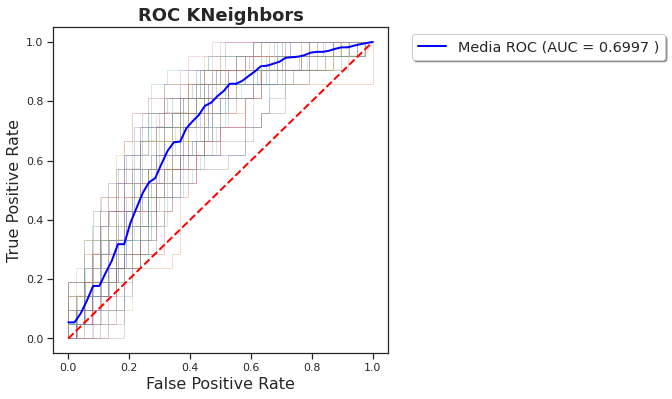

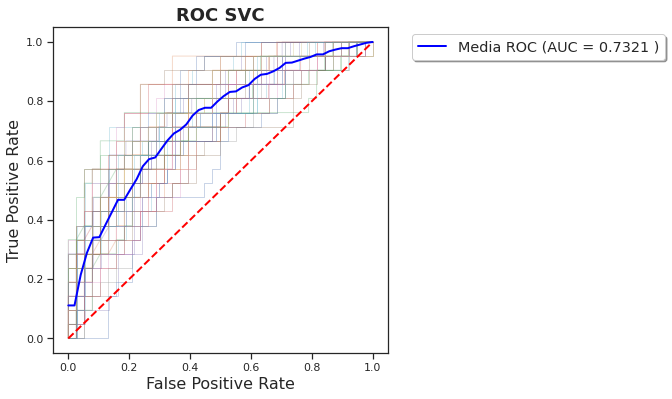

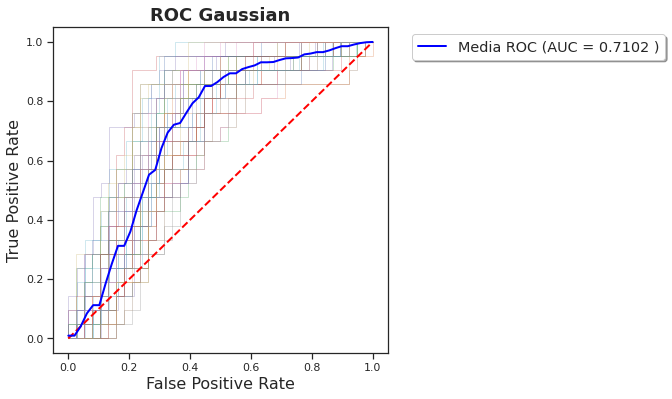

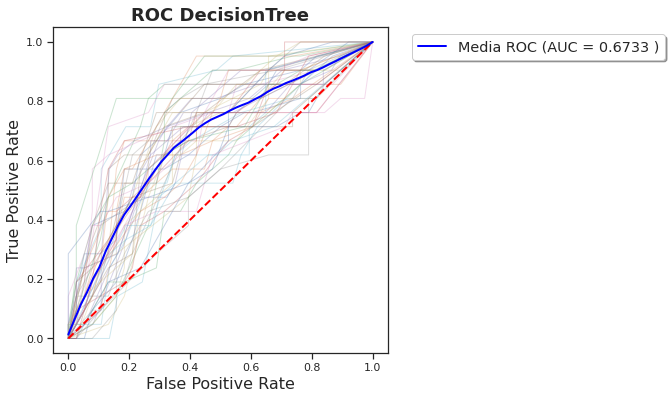

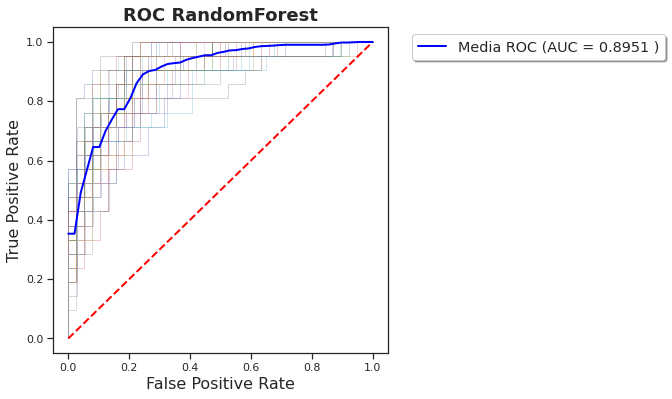

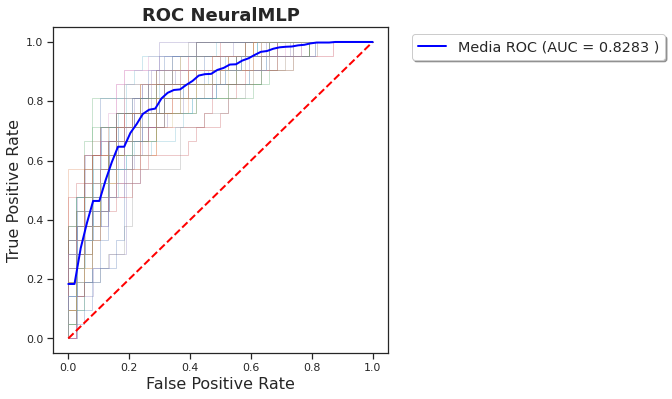

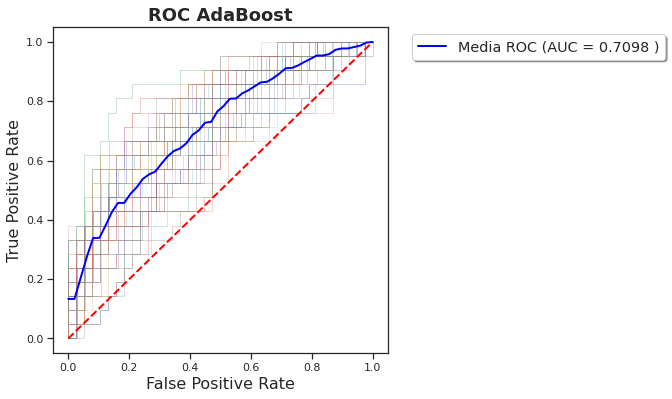

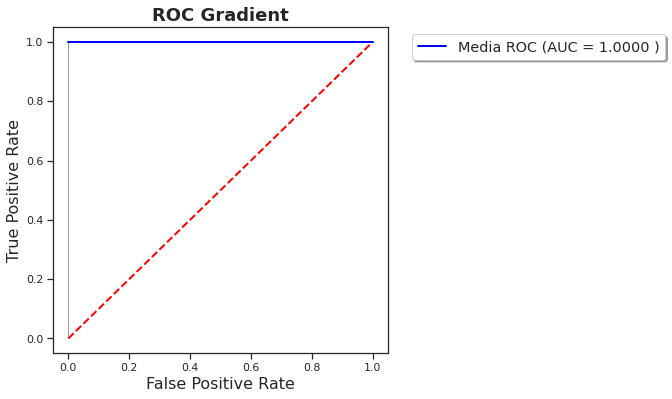

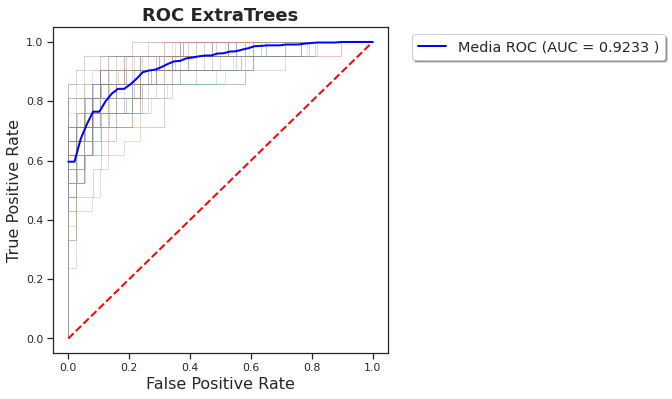

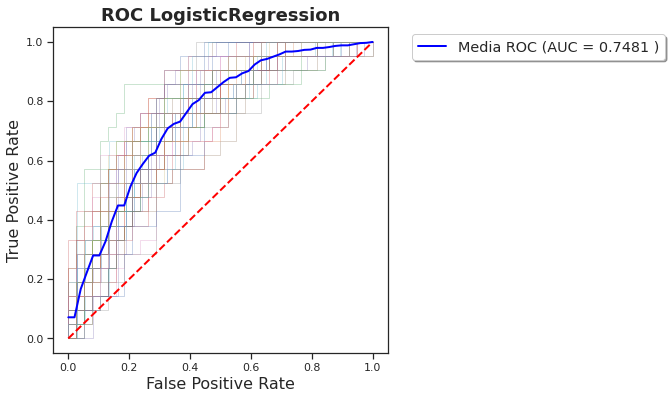

In [19]:
media_auc_hiper = plotar_media_curva_roc(names2, classes2, dados, 5, 10)

## Comparação dos AUC médios 

Abaixo segue tabelas comparativas entre os AUC médios calculados pela plotagem dos gráficos dos modelos otimizados e o AUC médios obtidos pela função ```executa_modelos```. 

In [20]:
# executando plotar_media_curva_roc sem plotar os gráficos, apenas para obter a média.
media_auc_padrao = plotar_media_curva_roc(names, classes, dados, 5, 10, False)

### Tabela obtida pela plotagem do gráfico ROC.

In [21]:
help(montar_dataframe_medias_AUC)

Help on function montar_dataframe_medias_AUC in module funcoes:

montar_dataframe_medias_AUC(media_auc_padrao, media_auc_hiper)
    Função para montar um dataFrame com os retornos da função plotar_media_curva_roc()
    
    Parâmetros
    ----------
      media_auc_padrao: array com o resultado da função plotar_media_curva_roc() sobre
      os modelos default
      media_auc_hiper: array com o resultado da função plotar_media_curva_roc() sobre
      os modelos ajustados 
    
    Retorno
    -------
      dfretorno: dataFrame com o merge dos parâmetros de entrada e com a coluna de diferença



In [22]:
dfmediaAUC = montar_dataframe_medias_AUC(media_auc_padrao, media_auc_hiper)
dfmediaAUC

,Media_padrao,Media_Ajustado,diferenca (%)
Nome,,,
KNeighbors,0.663672,0.699703,3.603099
SVC,0.720785,0.732077,1.129252
Gaussian,0.710165,0.710165,0.000000
DecisionTree,0.601825,0.673349,7.152393
RandomForest,0.988687,0.895092,-9.359513
NeuralMLP,0.832216,0.828290,-0.392614
AdaBoost,0.673868,0.709835,3.596716
Gradient,0.981905,1.000000,1.809524
ExtraTrees,0.989603,0.923324,-6.627933


### Tabela obtida pela função ```roda_modelo_cv``` 

In [23]:
dfdiffAUC = pd.DataFrame(dfmodelos['ROC AUC']).merge(pd.DataFrame(dfmodelos_ajustados['ROC AUC']), on="Nome")
dfdiffAUC.columns = ['AUC padrao','AUC ajustado']
dfdiffAUC['diferenca (%)'] = (dfdiffAUC['AUC ajustado'] - dfdiffAUC['AUC padrao']) * 100
dfdiffAUC.sort_values('AUC ajustado', ascending=False)

,AUC padrao,AUC ajustado,diferenca (%)
Nome,,,
RandomForest,0.759487,0.778388,1.890063
Gradient,0.737192,0.761938,2.474565
ExtraTrees,0.737661,0.755712,1.805121
LogisticRegression,0.745859,0.750232,0.437242
NeuralMLP,0.739838,0.743558,0.371943
SVC,0.723426,0.735974,1.254826
AdaBoost,0.671912,0.717203,4.529127
Gaussian,0.714948,0.714948,0.000000
KNeighbors,0.667262,0.700238,3.297568


In [24]:
dfAnalise = dfdiffAUC.merge(dfmediaAUC, on="Nome")

* Visualização do destaque da cor azul fica prejudicada no GitHub.

In [25]:
def destaca_maiores_valores(valor): 
   cor = 'blue' if valor > 0.75 else 'black'
   return f'color: {cor}'

In [26]:
dfAnalise.style.applymap(destaca_maiores_valores, subset=pd.IndexSlice[:, ['AUC padrao','AUC ajustado','Media_padrao','Media_Ajustado']])

,AUC padrao,AUC ajustado,diferenca (%)_x,Media_padrao,Media_Ajustado,diferenca (%)_y
Nome,,,,,,
KNeighbors,0.667262,0.700238,3.297568,0.663672,0.699703,3.603099
SVC,0.723426,0.735974,1.254826,0.720785,0.732077,1.129252
Gaussian,0.714948,0.714948,0.000000,0.710165,0.710165,0.000000
DecisionTree,0.594252,0.674503,8.025164,0.601825,0.673349,7.152393
RandomForest,0.759487,0.778388,1.890063,0.988687,0.895092,-9.359513
NeuralMLP,0.739838,0.743558,0.371943,0.832216,0.828290,-0.392614
AdaBoost,0.671912,0.717203,4.529127,0.673868,0.709835,3.596716
Gradient,0.737192,0.761938,2.474565,0.981905,1.000000,1.809524
ExtraTrees,0.737661,0.755712,1.805121,0.989603,0.923324,-6.627933


##Análise e seleção dos modelos

Para seleção do modelo vou considerar um **AUC > 0.74**.

###**KNeighbors**

Nos ajustes de hiperparâmetros tivemos um aumento de *3.29%* e na plotagem da Curva ROC um aumento de *3.60%*, mas ainda assim a AUC ficou abaixo de 0.74, além de não apresentar uma curva ROC uniforme, sendo **descartado** da seleção.

###**SVC**

Nos ajustes de hiperparâmetros tivemos um aumento de *1.25%* e na plotagem da Curva ROC um aumento de *1.12%*, mas ainda assim a AUC ficou abaixo de 0.74 e apesar de apresentar uma curva ROC uniforme está sendo **descartado** da seleção.

###**Gaussian**

Não apresentou variação nos ajustes de hiperparâmetros e nem na plotagem da Curva ROC ficando com a AUC de 0.74, além de não apresentar uma curva ROC uniforme, sendo **descartado** da seleção.

###**DecisionTree**

Nos ajustes de hiperparâmetros tivemos um aumento de *8.02%* e na plotagem da Curva ROC um aumento de *7.15%*, mas ainda assim a AUC ficou abaixo de 0.74 e apesar de apresentar uma curva ROC uniforme está sendo **descartado** da seleção.

###**RandomForest**

Nos ajustes de hiperparâmetros tivemos um aumento de *1.89%* e na plotagem da Curva ROC um redução de **-9.35%**?.

Esse modelo teve uma variação bastante significativa entre o 'AUC ajustado' (0.778388) e a 'Media_Ajustado' (0.895092), quase 11% na área. Ainda estou investigando isso, mas provalvemnte deve ser por overfit com os valores default, aqui cabe um investigação.

A AUC da 'Media_Ajustado', ficou acima de 0.74, sendo um modelo **selecionável**.

###**NeuralMLP**

Nos ajustes de hiperparâmetros tivemos um aumento de *0.37%* e na plotagem da Curva ROC um descréscimo de *-0.39%*, com AUC da 'Media_Ajustado' acima de 0.74 e uma curva ROC uniforme é um modelo **selecionável**.

###**AdaBoost**
  
Nos ajustes de hiperparâmetros tivemos um aumento de *4.52%* e na plotagem da Curva ROC um aumento de *3.58%*, mas ainda assim a AUC ficou abaixo de 0.74, sendo **descartado** da seleção.  

###**Gradient**

Nos ajustes de hiperparâmetros tivemos um aumento de *2.47%* e na plotagem da Curva ROC um aumento de *1.80%*, a AUC ficou acima de 0.74 nos dois casos, porém cabe uma investição aqui, pois a AUC 'Media_Ajustado' ficou igual a **1.0**, extremamente ajustado. Vamos analisar isso. 





####***Avaliação do GradientBoostingClassifier()***



In [27]:
objTemp = dfmodelosRand.at['Gradient','objRandomizedSearchCV']
objTemp.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=6, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=160,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=73246, subsample=0.49677434214589056,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=True)

In [28]:
# AUC de Treino do modelo default
resultado = roda_modelo_cv(classes[n_Gradient], dados, 5, 10)
resultado['train_roc_auc']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
# AUC de Treino do modelo otimizado
resultado = roda_modelo_cv(objTemp.best_estimator_, dados, 5, 10)
resultado['train_roc_auc']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Temos um OVERFIT no modelo GradientBoostingClassifier() tanto no modelo padrão como no ajustado. Considerando a avaliação realizada é um modelo **descartado**.

###**ExtraTrees**

Nos ajustes de hiperparâmetros tivemos um aumento de *1.80%* e na plotagem da Curva ROC um decréscimo de *-6.62%*, a AUC ficou acima de 0.74 nas duas situações, cabe aqui uma análise mais detalhada.

É um modelo **selecionável** pelos valores apresentados.

###**LogisticRegression**

Nos ajustes de hiperparâmetros tivemos um aumento de *0.42%* e na plotagem da Curva ROC um aumento de *0.16%*, com a AUC acima 0.74 nas duas situações e  apresentar uma curva ROC uniforme, é um modelo **selecionável**.



---



Vamos continuar com os seguintes modelos:

* RandomForest

* NeuralMLP

* ExtraTrees

* Logistic Regression





#Matriz de confusão

Até aqui o processo de treino e teste dos modelos foi realizado utilizando RepeatedStratifiedKFold assim, a métrica AUC e a plotagem dos gráficos ROC foi baseada na média, para a apresentação da matriz de confusão foi utilizado train_test_split com proporção 70/30 para os dados de treino/teste.

Vamos selecionar alguns dos modelos para plotar a matriz de confusão.


In [30]:
names_matriz = ["NeuralMLP", "ExtraTrees", "RandomForest", "LogisticRegression" ]

modelos_matriz = [ dfmodelosRand.at['NeuralMLP','Modelo'], 
                   dfmodelosRand.at['ExtraTrees','Modelo'], 
                   dfmodelosRand.at['RandomForest','Modelo'], 
                   dfmodelosRand.at['LogisticRegression','Modelo'] ]                   

In [31]:
help(plotar_matrix_confusao_modelos)

Help on function plotar_matrix_confusao_modelos in module funcoes:

plotar_matrix_confusao_modelos(names, models, dados, nrows, ncols)
    Plotar a Matriz de Confusão de vários modelos.
    
    Parâmetros
    ----------
      names: array com os nomes dos modelos.  ex.: names = [ "KNeighbors", "Gaussian" ]
      models: array com a instância do modelo a ser plotado.
               ex.: classes = [ KNeighborsClassifier(), 
                                GaussianProcessClassifier() ]
      dados: dataFrame com os dados
      nrows: quantidade de linhas no gráfico
      ncols: quantidade de colunas no gráfico
    
    Retorno
    -------
      Sem retorno.



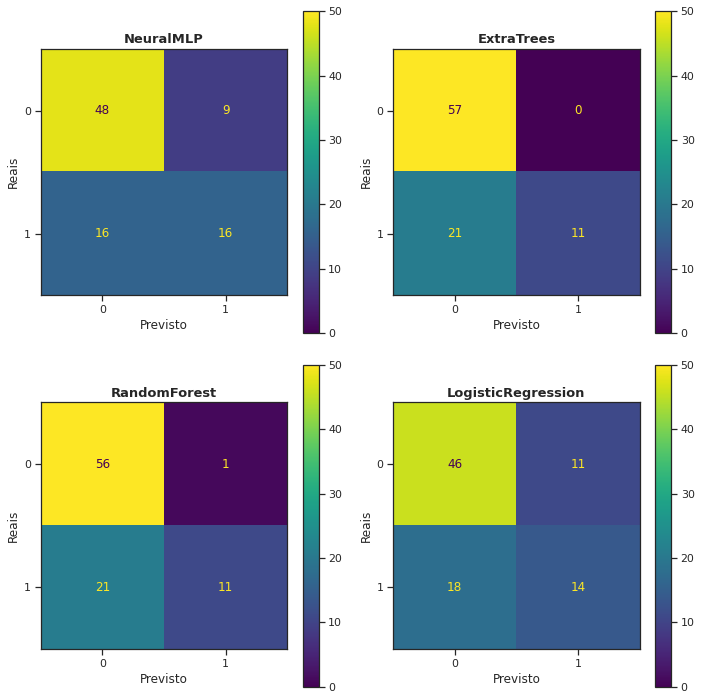

In [32]:
plotar_matrix_confusao_modelos(names_matriz, modelos_matriz, dados, 2, 2)

#Classification Report

Há outras métricas que podem ser obtidas a partir dos nossos modelos e a função classification_report nos apresenta a accuracy, precision, recall e o f1-score.

Segue abaixo a tabela Classification Report dos modelos selecionados.

In [33]:
help(montar_classificacao)

Help on function montar_classificacao in module funcoes:

montar_classificacao(names, models, dados)
    Montar um dataFrame com o resultado do classification_report.
    
    Parâmetros
    ----------
      names: array com o nome dos modelos
      models: array com a instancia do Modelo de Machine Learning.
      dados: dataFrame com os dados
    
    Retorno
    -------
      dfretorno: dataFrame populado



In [34]:
dffinal = montar_classificacao(names_matriz, modelos_matriz, dados)
dffinal.T

0        1 accuracy macro avg weighted avg
NeuralMLP          precision 0.750000 0.640000           0.695000     0.710449
                   recall    0.842105 0.500000           0.671053     0.719101
                   f1-score  0.793388 0.561404 0.719101  0.677396     0.709978
                   support         57       32       89        89           89
ExtraTrees         precision 0.730769 1.000000           0.865385     0.827571
                   recall    1.000000 0.343750           0.671875     0.764045
                   f1-score  0.844444 0.511628 0.764045  0.678036     0.724780
                   support         57       32       89        89           89
RandomForest       precision 0.727273 0.916667           0.821970     0.795369
                   recall    0.982456 0.343750           0.663103     0.752809
                   f1-score  0.835821 0.500000 0.752809  0.667910     0.715076
                   support         57       32       89        89           89
LogisticRegression precision 0.718750 0.560000           0.639375     0.661671
                   recall    0.807018 0.437500           0.622259     0.674157
                   f1-score  0.760331 0.491228 0.674157  0.625779     0.663575
                   support         57       32       89        89           89

In [35]:
help(montar_dataframe_avaliacao)

Help on function montar_dataframe_avaliacao in module funcoes:

montar_dataframe_avaliacao(names_matriz, df_from_montar_classificacao, df_from_medias_AUC)
    Função para montar um dataFrame com as informações dos parâmetros.
    
    Parâmetros
    ----------
      names_matriz: array com os nomes dos modelos
      df_from_montar_classificacao: resultado da função montar_classificacao()
      df_from_medias_AUC: resultado da função montar_dataframe_medias_AUC()
    
    Retorno
    -------
      dfretorno: dataFrame com o merge dos parâmetros de entrada



In [36]:
dfavaliacao = montar_dataframe_avaliacao(names_matriz, dffinal, dfmediaAUC)
dfavaliacao

,Precision 0,Precision 1,Recall 0,Recall 1,F1-Score 0,F1-Score 1,Accuracy,AUC
Nome,,,,,,,,
NeuralMLP,0.750000,0.640000,0.842105,0.500000,0.793388,0.561404,0.719101,0.828290
ExtraTrees,0.730769,1.000000,1.000000,0.343750,0.844444,0.511628,0.764045,0.923324
RandomForest,0.727273,0.916667,0.982456,0.343750,0.835821,0.500000,0.752809,0.895092
LogisticRegression,0.718750,0.560000,0.807018,0.437500,0.760331,0.491228,0.674157,0.748095


#Modelo Selecionado

Considerando os resultados o modelo selecionado foi o **ExtraTreesClassifier**()

Com a seguinte configuração:

In [37]:
#Setar modelo com o escolhido.
modelo = dfmodelosRand.at['ExtraTrees','Modelo']

In [38]:
objTemp = dfmodelosRand.at['ExtraTrees','objRandomizedSearchCV']
objTemp.best_estimator_

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=6, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=4, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=917,
                     n_jobs=None, oob_score=False, random_state=73246,
                     verbose=0, warm_start=True)

In [39]:
objTemp.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 4,
 'n_estimators': 917}

In [40]:
help(plotar_matrix_confusao)

Help on function plotar_matrix_confusao in module funcoes:

plotar_matrix_confusao(model, dados)
    Plotar a Matriz de Confusão de um modelo
    
    Parâmetros
    ----------
      model: modelo a ser plotado.
      dados: dataFrame com os dados
    
    Retorno
    -------
      Sem retorno.



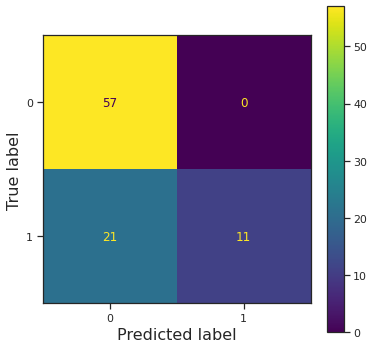

In [41]:
plotar_matrix_confusao(modelo, dados)

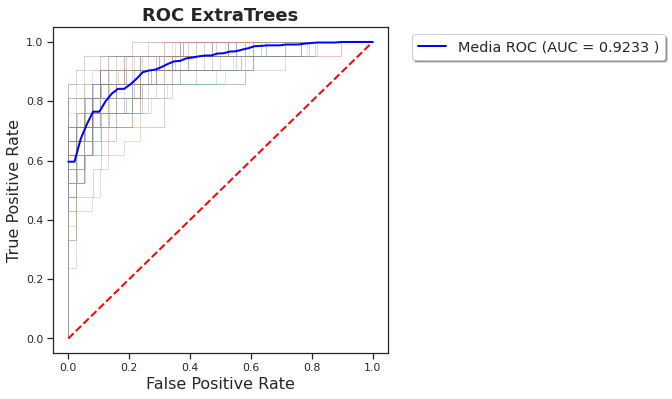

[['ExtraTrees', 0.9233236151603497]]

In [42]:
plotar_media_curva_roc(["ExtraTrees"], [modelo], dados, 5, 10, True)

Plotando com a função default do sklearn.metrics.plot_roc_curve.

No handles with labels found to put in legend.


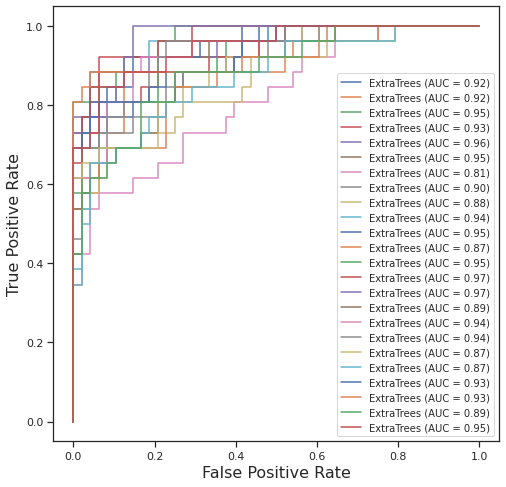

In [44]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(8,8))

x_columns = dados.columns
y = dados['ICU']
x = dados[x_columns].drop(["ICU"], axis=1)
np.random.seed(rstate)
mpl.rcParams['legend.fontsize']= 'small'
ax.legend(loc='best', bbox_to_anchor=(2, 2), frameon=True, shadow=True)

for i in range(1,25):
  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)
  modelo.fit(X_train, y_train)
  plot_roc_curve(modelo, X_test, y_test, ax=ax, name='ExtraTrees')

# Salvando nosso modelo

O módulo **[pickle]((https://docs.python.org/3/library/pickle.html)** implementa protocolos binários para serializar e desserializar a estrutura de um objeto Python.</p>


In [45]:
import pickle

# Treinando o modelo com todos os dados antes de salvar.
x_columns = dados.columns
y = dados['ICU']
x = dados[x_columns].drop(["ICU"], axis=1)

modelo.fit(x,y)

output = open('/content/modelo_hsl', 'wb')
pickle.dump(modelo, output)
output.close()

# Conclusão

---

Após analisar vários modelos de Machine Learning, ajustando Hiperparâmetros, visualizando a curva ROC, Matriz de confusão, Classification Report cheguei a conclusão que o melhor modelo é o **ExtraTreesClassifier** para atender a problema proposto.

Cabe salientar que trata-se de um projeto de conclusão de curso sobre Data Science, e ainda há muito a estudar, explorar e melhorar.



#Sugestão de Estudo

* Explorar a classe [Lazy Predict](https://towardsdatascience.com/lazy-predict-fit-and-evaluate-all-the-models-from-scikit-learn-with-a-single-line-of-code-7fe510c7281) que realiza uma avaliação inicial de vários modelos de Machine Learning e ampliar a possibilidde de estudo de outros modelos além dos apresentados aqui.

* Utilização de pipeline

* Observar feature selection e feature importance.

* Analisar melhor o **GradientBoostingClassifier()** ajustando os hiperparâmetros para não ocorrer OVERFIT.

* Investigar a variação apresentada entre a 'AUC ajustado' (0.778388) e a 'Media_Ajustado' (0.895092), quase 11% na área, no processamento da **RandomForestClassifier()**


#Referências

* [Hospital Sírio-Libanês](https://www.hospitalsiriolibanes.org.br/Paginas/nova-home.aspx)
* [Kaggle - COVID-19 - Clinical Data to assess diagnosis - Sírio Libanês](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
* [SciKit Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Os Três Tipos de Aprendizado de Máquina](https://lamfo-unb.github.io/2017/07/27/tres-tipos-am/)
* [Enriched Lightgbm | PR 86% - notebook](https://www.kaggle.com/andrewmvd/enriched-lightgbm-pr-86-auc-92-68)
* [PedroHCAlmeida - notebook](https://github.com/PedroHCAlmeida/Bootcamp_alura/blob/main/Modulo_4/Aulas/Aulas.ipynb)
* [willianrocha (notebook)](https://github.com/willianrocha/COVID-19_clinical_data_assess_diagnosis/blob/main/notebooks/ML.ipynb)
* [Configurar o treinamento do AutoML com Python](https://docs.microsoft.com/pt-br/azure/machine-learning/how-to-configure-auto-train)
* [Avaliando os resultados do experimento de machine learning automatizado](https://docs.microsoft.com/pt-br/azure/machine-learning/how-to-understand-automated-ml)
* [Matriz de Confusão e AUC ROC](https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107)
* [SciKit Learn - 3.3. Metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [SciKit Learn - Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)


